In [1]:
import numpy as np
from aicspylibczi import CziFile
from pathlib import Path
import matplotlib.pyplot as plt

Loading metadata from the Carl Zeiss Image format via [aicspylibczi](https://github.com/AllenCellModeling/aicspylibczi)

In [3]:
pth = Path("data/su_example_set.czi")
czi = CziFile(pth)
# Get the shape of the data, the coordinate pairs are (start index, size)
dimensions = czi.get_dims_shape()
print(dimensions) 

[{'X': (0, 150), 'Y': (0, 150), 'Z': (0, 1), 'C': (0, 32), 'T': (0, 1), 'V': (0, 1), 'B': (0, 1)}]


Here I define a helper function so I can plot the images easier using matplotlib

In [4]:
def norm8bit(im):
    # normalizes an image to min = 0 and max = 255 / 8bit format
    im = im - im.min()
    im = im.astype(np.float32)
    im = im / im.max()
    im = im * 255
    im = im.astype(np.uint8)
    return im

[('B', 1), ('V', 1), ('T', 1), ('C', 1), ('Z', 1), ('Y', 150), ('X', 150)]
(1, 1, 1, 1, 1, 150, 150)


Text(0.5, 1.0, 'single channel image')

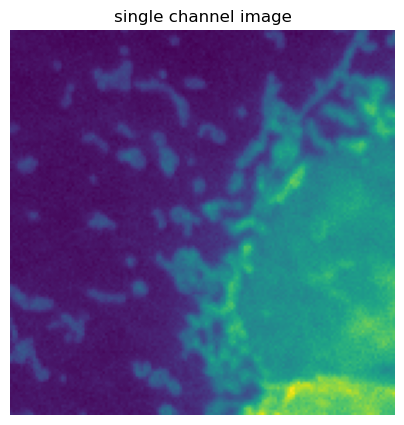

In [5]:
# Load the image slice I want from the file
img, shp = czi.read_image(C=13)
print(shp)
print(img.shape)


im_8bit = norm8bit(img.squeeze())
plt.figure(figsize=(5, 5))
plt.imshow(im_8bit)
plt.axis('off')
plt.title('single channel image')

Here some other helper function to load **spectral data** into a numpy arrray

In [6]:
def loadCZISpecData(pth):
    try:
        pth.exists()
    except:
        raise Exception("input path does not exist, was it created via Path()?")

    assert pth.__str__().endswith('.czi'),"path is not a czi file"
    
    ## doing some sanity checks
    czi = CziFile(pth)
    cidx = czi.dims.find('C')


    assert cidx != -1,"Could not find channels"
    print(f"Channels are located in index {cidx}")
    nChannels = czi.size[cidx]
    print(f"Image has {nChannels} channels")

    assert czi.dims.endswith("YX"),"Unexpected arrangement of the dims"

    for x in range(nChannels):
        if x==0:
            #print("fisrt iteration")
            img = loadCZIChannel(czi, x)
            specData = np.tile(img, [nChannels, 1, 1])
        else:
            #print(f"iteration index: {x}")
            img = loadCZIChannel(czi, x)
            specData[x,:,:] = img

    

    return specData

def loadCZIChannel(czi, idx):
    # loads single channel from a czi opbject
    cData, tmp = czi.read_image(C=idx)
    cData = cData.squeeze()
    assert len(cData.shape)==2,"unxpected size of image"
    return cData

In [7]:
sData = loadCZISpecData(pth)
print(sData.shape)

Channels are located in index 3
Image has 32 channels
(32, 150, 150)


This help+er function now take a spectral dataset and creates a RGB image from the array

In [8]:
def RGB_from_spec(specData, do_norm=False):
    # creates RGB image from specData (numpy array- dim 0: channels, dim 1, 2: spatial)
    nSpec = specData.shape[0]
    print(f'numver of spec: {nSpec}')
    idx = np.round(np.linspace(0, nSpec-1, num=4)).astype(int)
    
    B = specData[idx[0]:idx[1],:,:]
    B = np.mean(B, axis=0).astype(int)
    
    G = specData[idx[1]:idx[2],:,:]
    G = np.mean(G, axis=0).astype(int)
    
    R = specData[idx[2]:,:,:]
    R = np.mean(R, axis=0).astype(int)
    
    RGB = np.dstack([R, G, B])

    if do_norm:
        RGB = norm8bit(RGB)
    
    return RGB

numver of spec: 32


(-0.5, 149.5, 149.5, -0.5)

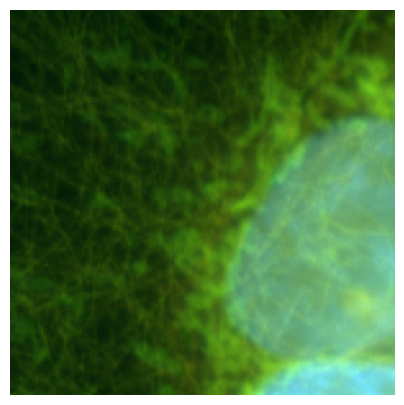

In [9]:
RGB_im = RGB_from_spec(sData, do_norm=True)

plt.figure(figsize=(5, 5))
plt.imshow(RGB_im)
plt.axis('off')

I am not very happy withthis basic view, thus I will import these **channels** into a napari viewer

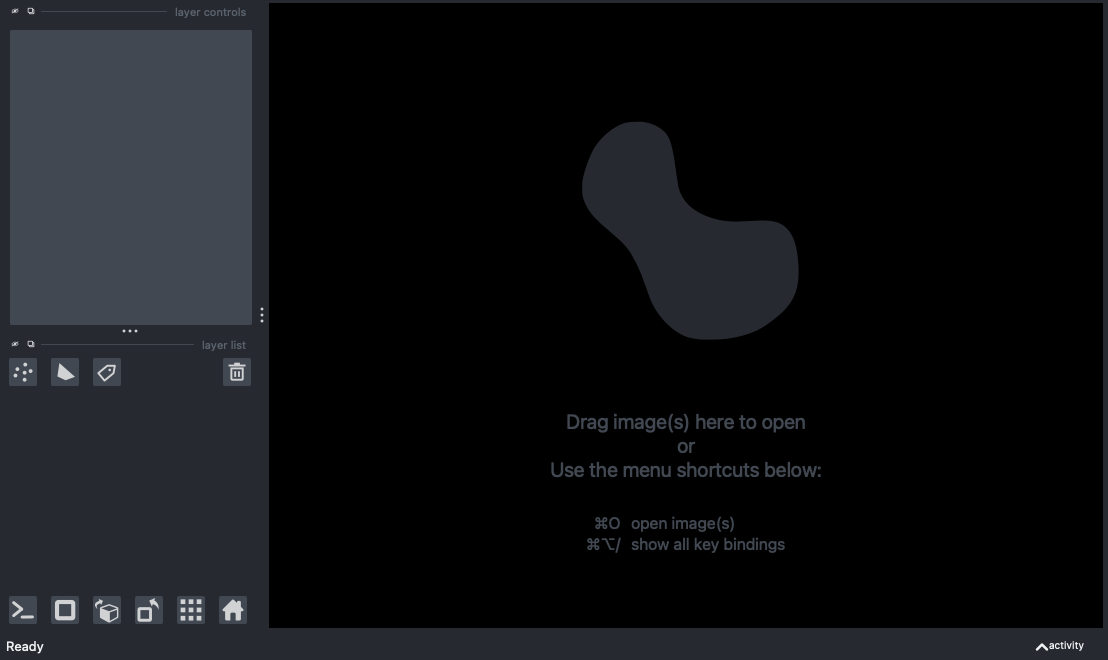

In [10]:
import napari
from napari.utils import nbscreenshot
viewer = napari.Viewer()
nbscreenshot(viewer)

I first check the dimentions of the array, to know where to access the channels

In [11]:
RGB_im.shape

(150, 150, 3)

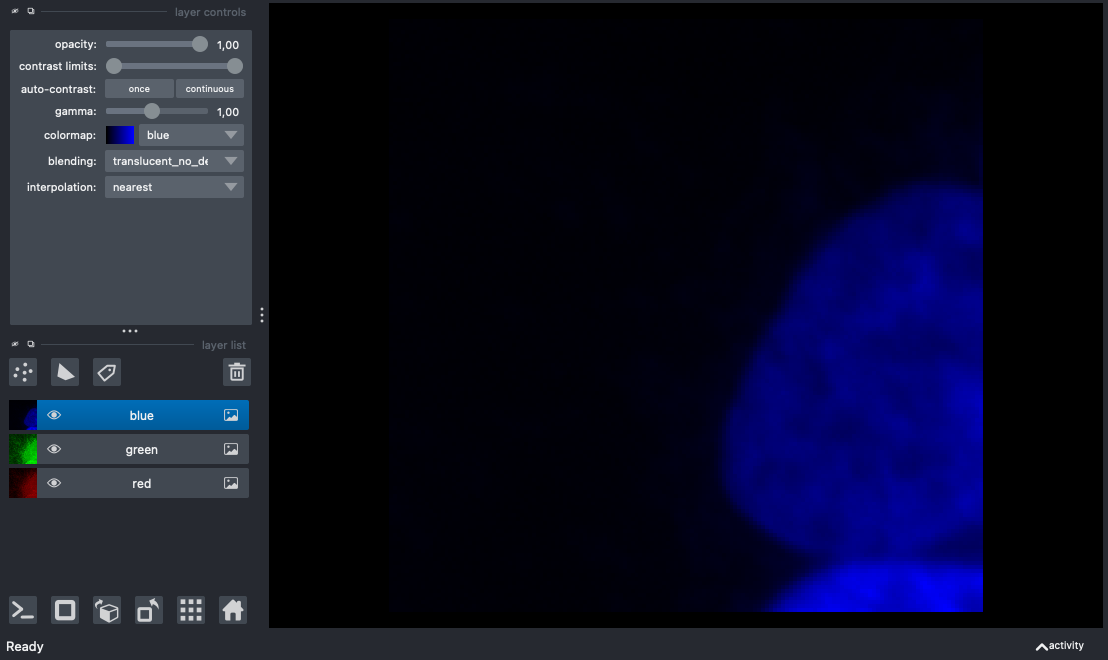

In [12]:
R = RGB_im[:,:,0]
G = RGB_im[:,:,1]
B = RGB_im[:,:,2]
viewer.add_image(R, name = 'red')
viewer.layers['red'].colormap = 'red'

viewer.add_image(G, name = 'green')
viewer.layers['green'].colormap = 'green'


viewer.add_image(B, name = 'blue')
viewer.layers['blue'].colormap = 'blue'


nbscreenshot(viewer)

Notice how I can only see one channel at the time, this is due to the blending option of the layers

In [13]:
viewer.layers['blue'].blending

'translucent_no_depth'

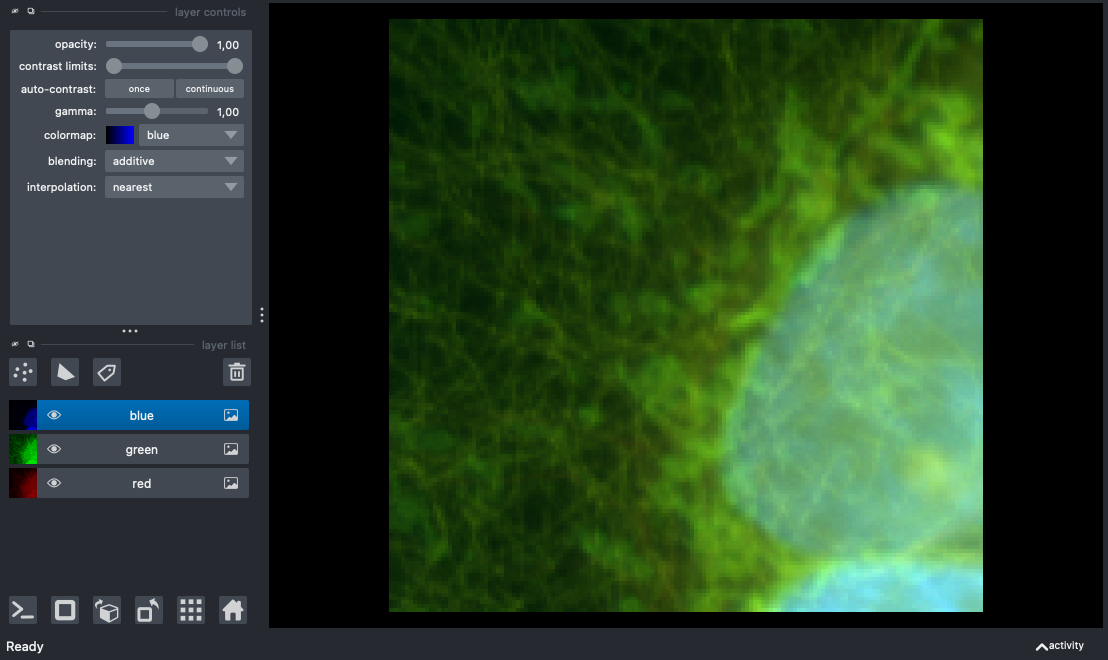

In [14]:
viewer.layers['blue'].blending = 'additive'
viewer.layers['green'].blending = 'additive'
viewer.layers['red'].blending = 'additive'
nbscreenshot(viewer)

Now let us modify by hand a create a nother screenshot afterwards

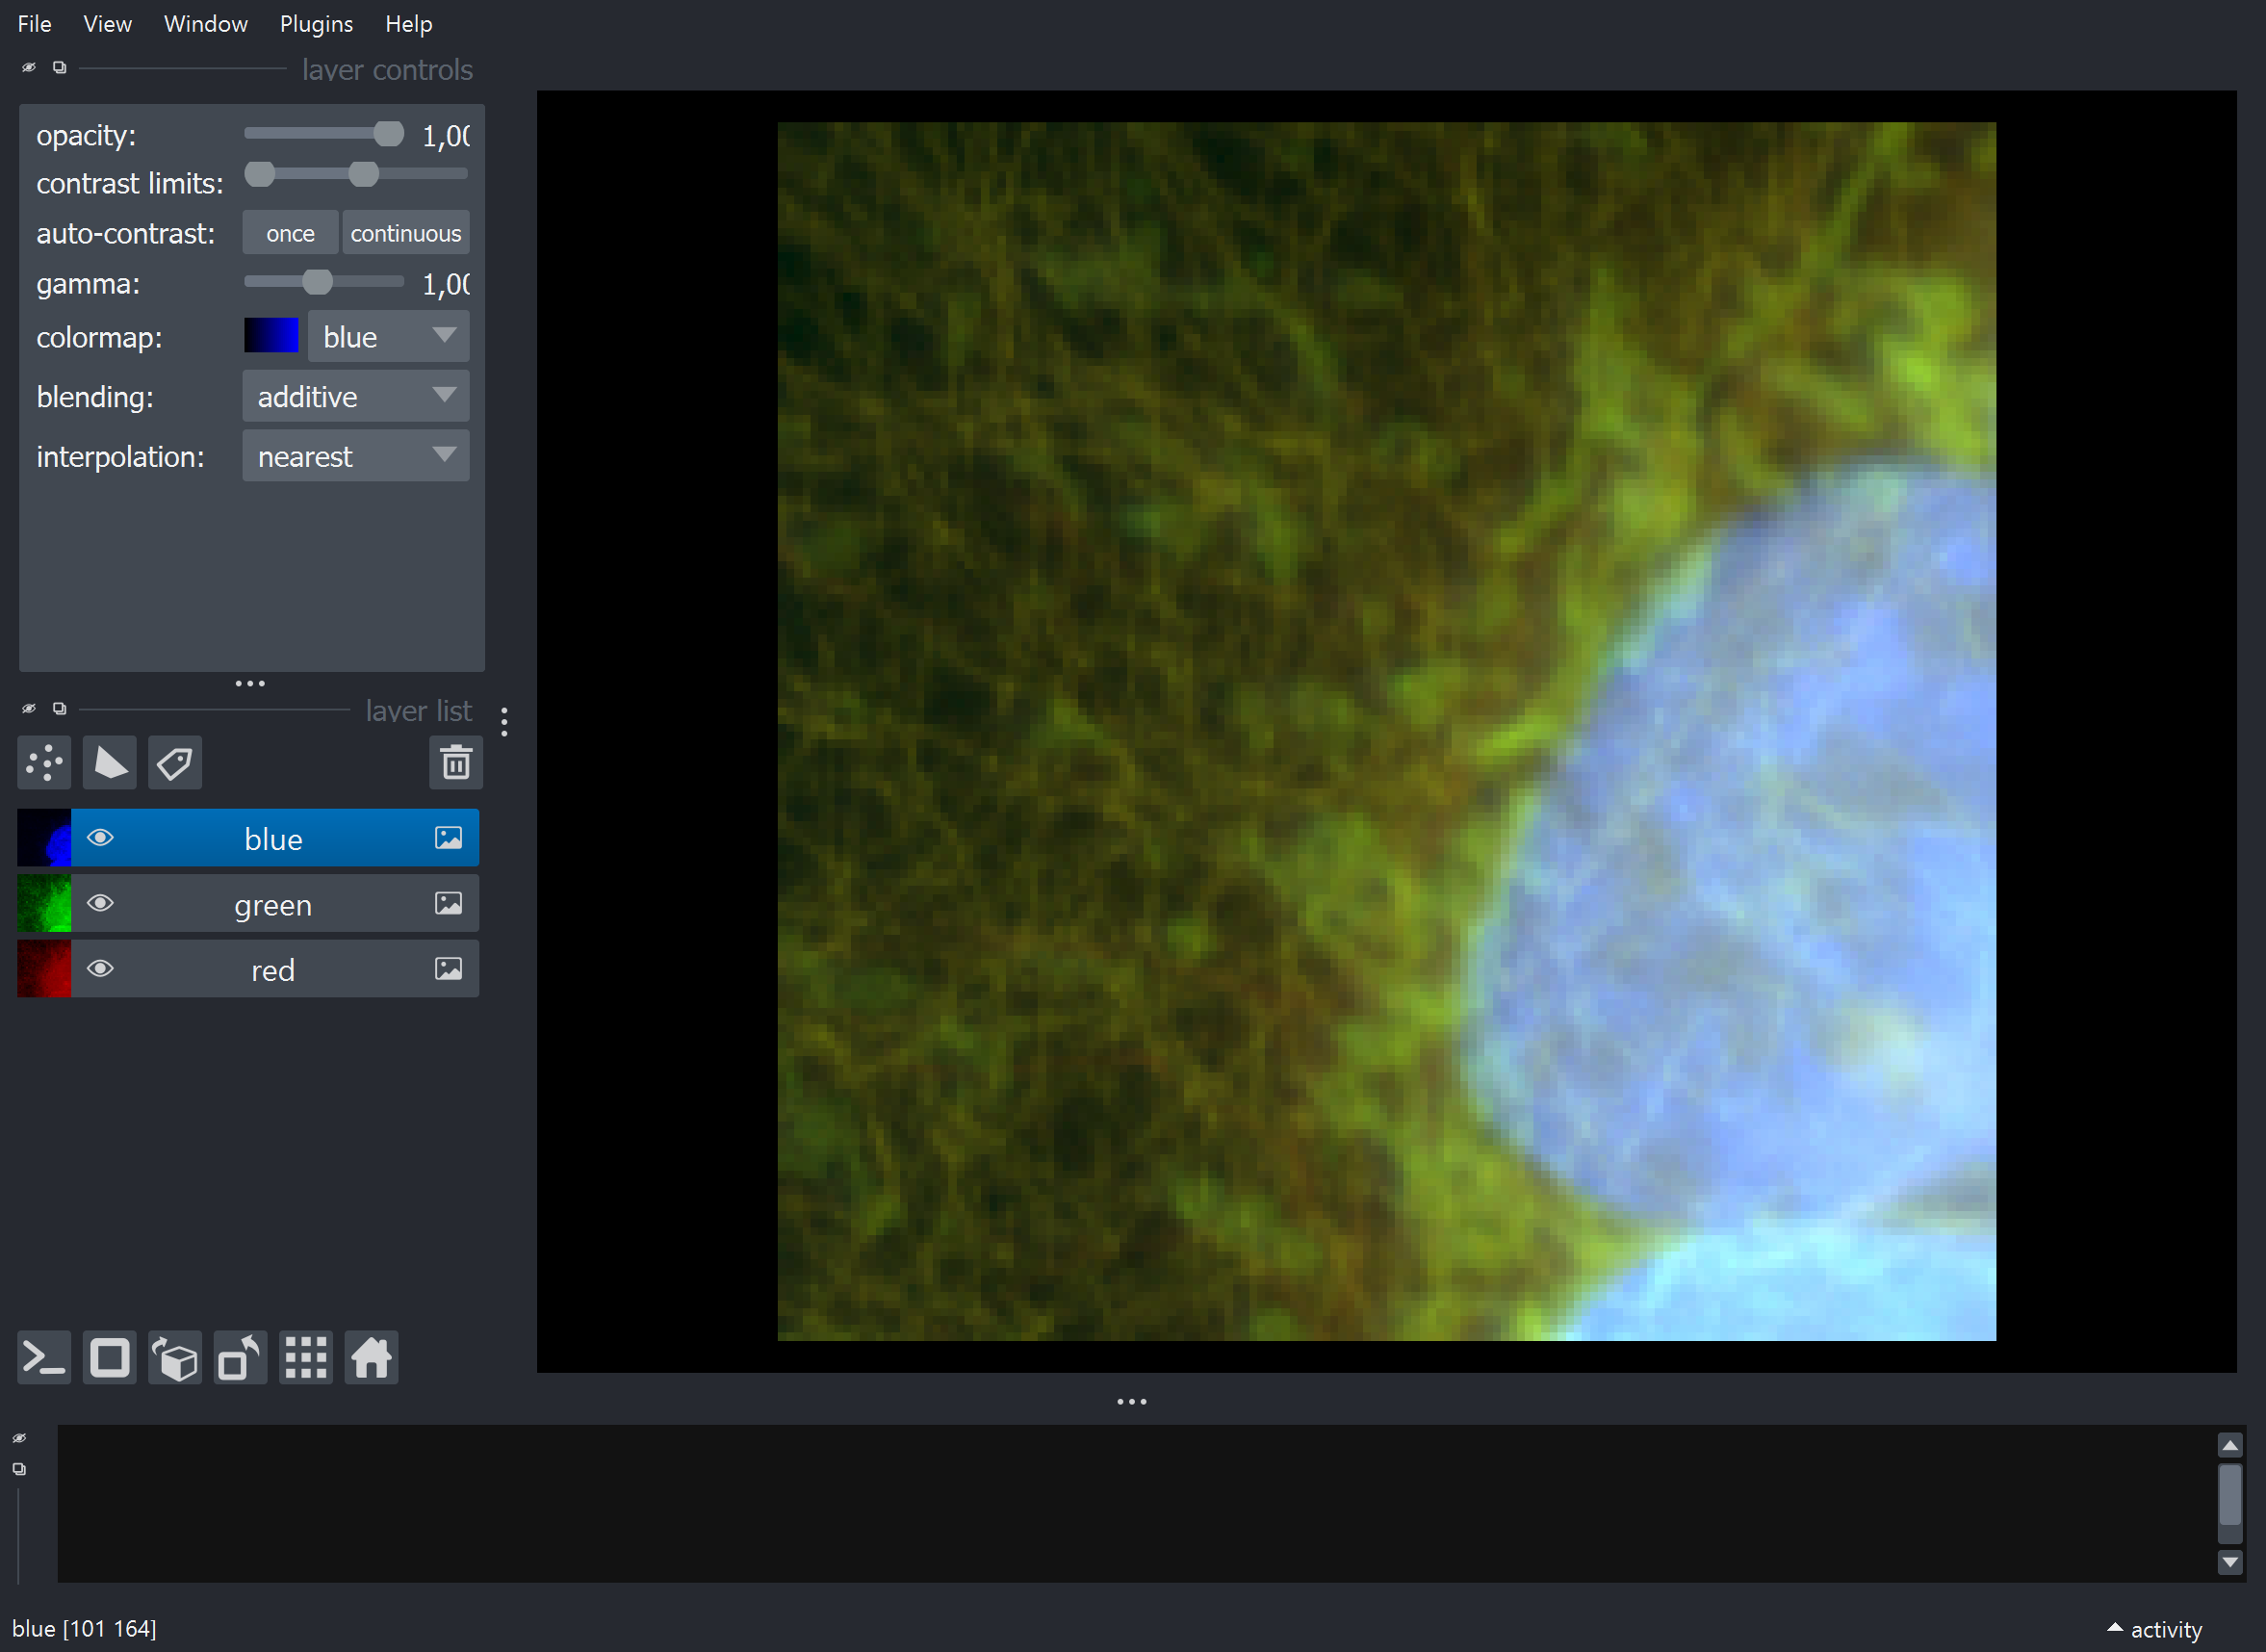

In [20]:
nbscreenshot(viewer)